# Image Classifier

For this project it was collected an image dataset using a webcam. Then a neural network from scratch
was builded, trained and test. It was also used a pre-trained neural network model (VGG16). 

In [66]:
# Import needed libraries
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import classification_report
from sklearn.utils import shuffle

import os
import cv2 
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras_preprocessing.image import load_img
from tensorflow.keras.models import load_model


In [67]:
class_names = ['apple', 'bottle', 'bodycream', 'yoda']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

print(class_names_label)

IMAGE_SIZE = (224,224)

{'apple': 0, 'bottle': 1, 'bodycream': 2, 'yoda': 3}


In [68]:
# Loading the data
def load_data():
    DIRECTORY = r'/Users/CristaVillatoro/Desktop/tahini-tensor-student-code/week9/imageclassifier/data/'
    CATEGORY = ['train', 'test' ]
    
    output = []

    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []

        print('Loaded {}'.format(category))

        for folder in os.listdir(path):
            if folder.startswith('.'):
                continue
            label = class_names_label[folder]

            # Iterate through each image in the folder
            for file in os.listdir(os.path.join(path,folder)):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(path, folder), file)
    
                
                # Open and resize the img
                image = cv2.imread(img_path)
                if image is None:
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype= 'int32')

        output.append((images, labels))
    return output


In [69]:
(Xtrain , ytrain),(Xtest, ytest) = load_data()

Loaded train
Loaded test


In [70]:
# Checking shapes:
print('Xtrain shape:', Xtrain.shape)
print(Xtrain.shape[0], 'train samples')
print(Xtest.shape[0], 'test samples')
print(Xtrain[0].shape, 'image shape')
print('ytrain shape:', ytrain.shape)

Xtrain shape: (630, 224, 224, 3)
630 train samples
188 test samples
(224, 224, 3) image shape
ytrain shape: (630,)


In [71]:
#To better train the model, the train dataset was shuffle
 
Xtrain , ytrain = shuffle(Xtrain, ytrain , random_state = 25)

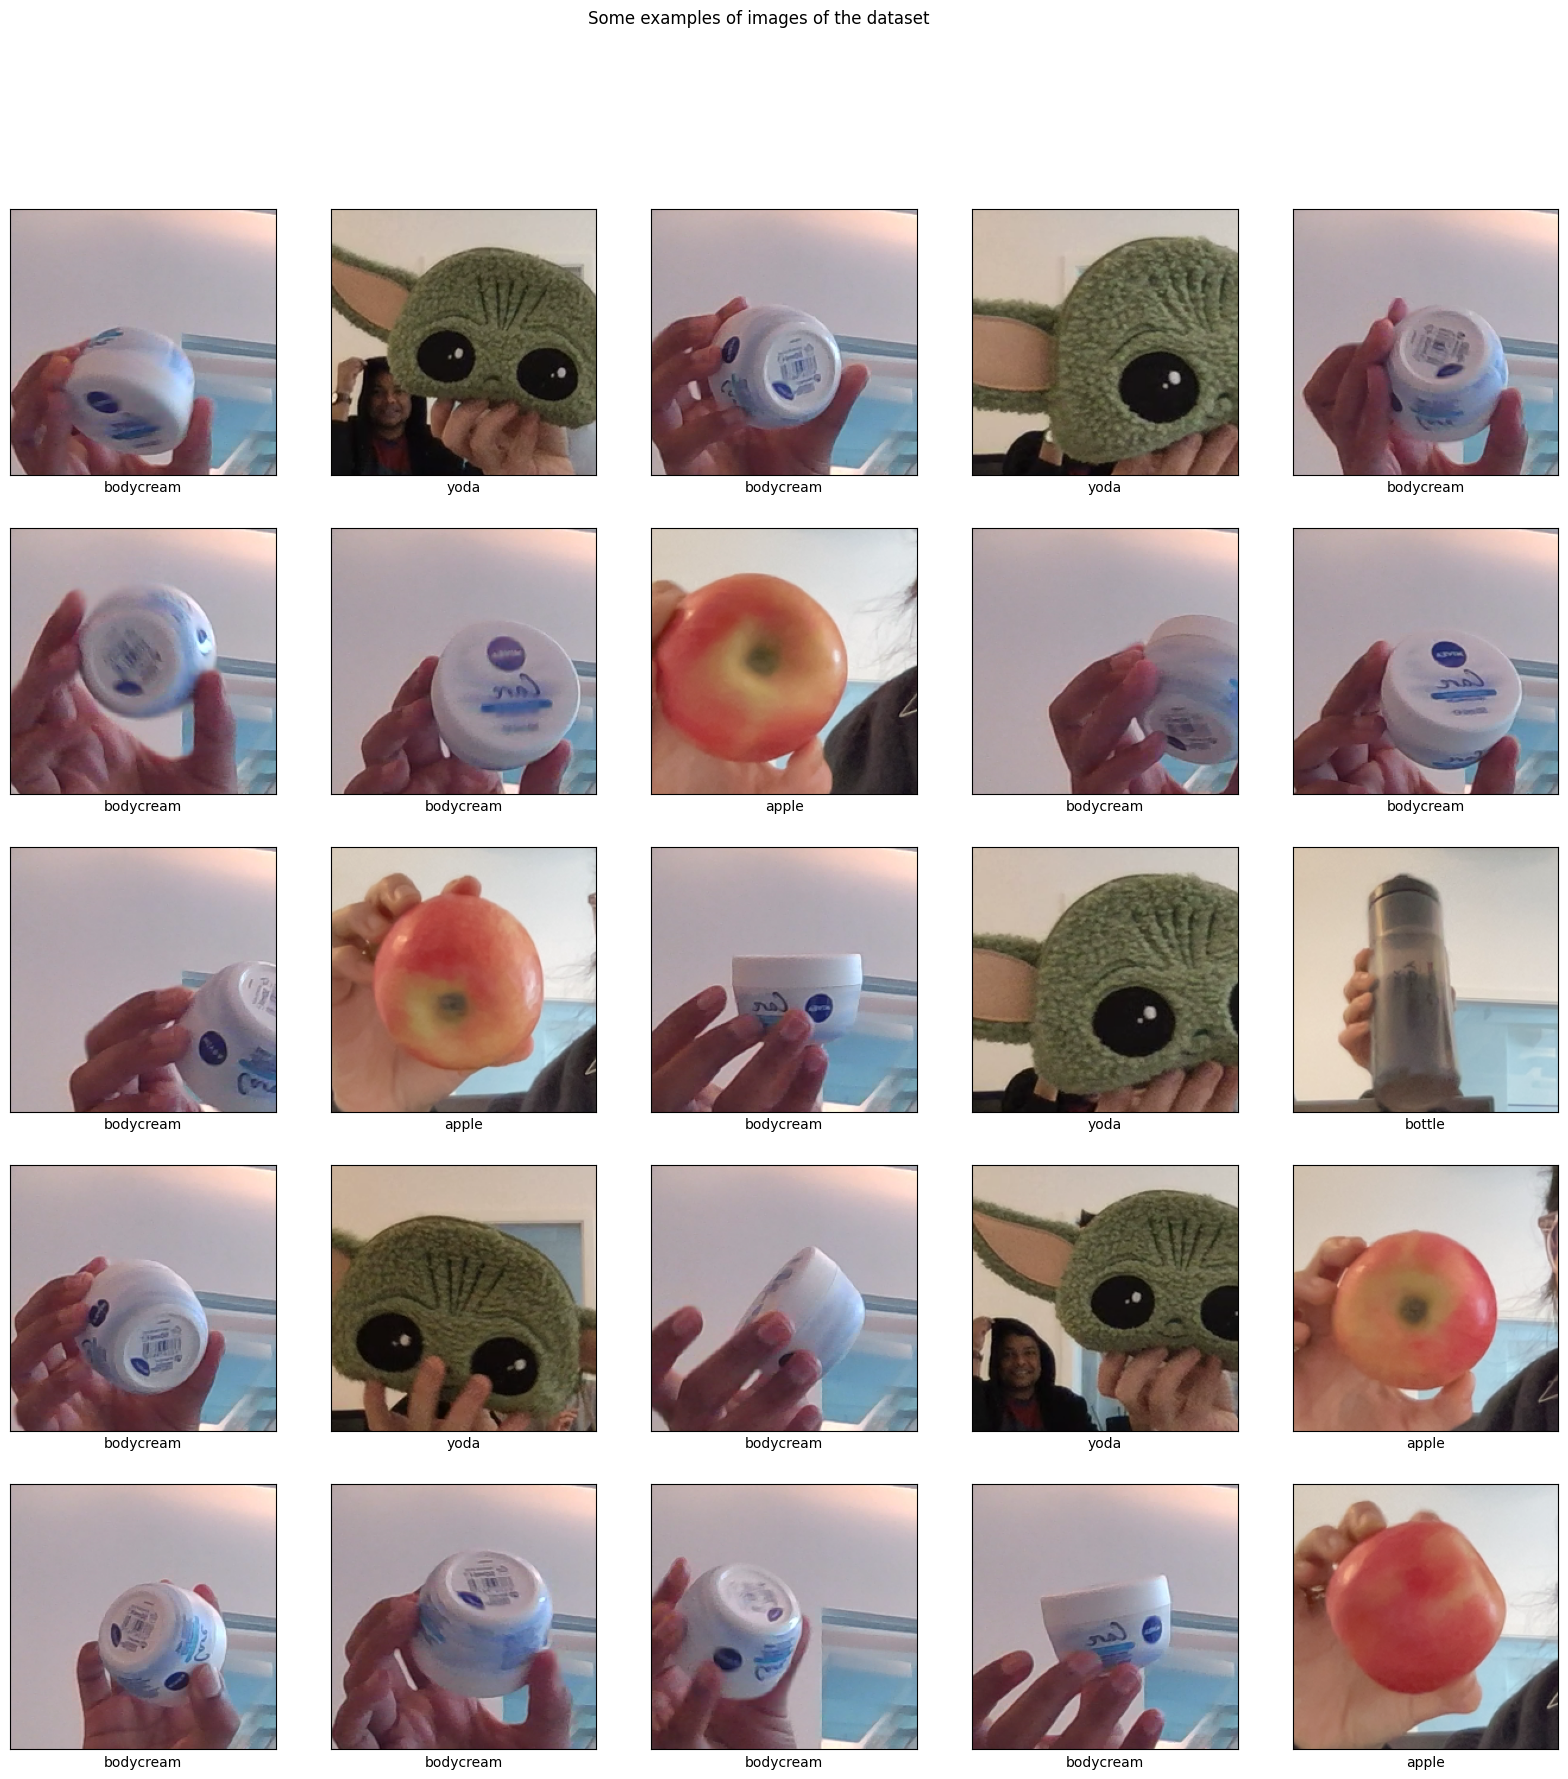

In [72]:
def display_examples(class_names, images, labels):
    ''' 
    Display 25 images from the images array with its corresponding labels
    '''

    figsize = (20,20)
    fig = plt.figure(figsize=figsize)
    fig.suptitle('Some examples of images of the dataset')
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        #image = cv2.resize(images[i], figsize) -> used if it is necessary to show less pixels
        #plt.imshow(image.astype(np.uint8))
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]])
    plt.show()
display_examples(class_names, Xtrain, ytrain)

### Model

In [73]:

# Relu for small dataset
# Softmax for multi classification
model = tf.keras.Sequential([
    # First convolutional layer with 32 filters and a 3x3 kernel
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    # Max pooling layer to reduce spatial dimensions by half
    tf.keras.layers.MaxPooling2D(2,2),
    # Second convolutional layer with 64 filters and a 3x3 kernel
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    # Max pooling layer to reduce spatial dimensions by half
    tf.keras.layers.MaxPooling2D(2,2),
    # Third convolutional layer with 128 filters and a 3x3 kernel
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    # Max pooling layer to reduce spatial dimensions by half
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten layer to convert output of previous layer to a 1D vector
    tf.keras.layers.Flatten(),
    # First dense layer with 256 units and ReLU activation
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    # Dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.3),
    # Second dense layer with 128 units and ReLU activation
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    # Dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.5),
    # Output dense layer with number of units equal to number of classes and softmax activation
    tf.keras.layers.Dense(units=nb_classes, activation=tf.nn.softmax)
])

In [74]:
# Model compile
# Sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each 
# sample belongs exactly to one class) and 
# categorical crossentropy when one sample can have multiple classes or labels
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [75]:
# Early stopping:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=3, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
)

In [76]:
history = model.fit(Xtrain, ytrain, batch_size=60, epochs=6, validation_split=0.2, callbacks=[early_stop])

Epoch 1/6
9/9 [==============================] - 10s 999ms/step - loss: 112.6404 - accuracy: 0.3294 - val_loss: 2.3566 - val_accuracy: 0.5317
Epoch 2/6
9/9 [==============================] - 8s 943ms/step - loss: 1.9946 - accuracy: 0.5516 - val_loss: 0.2733 - val_accuracy: 0.8968
Epoch 3/6
9/9 [==============================] - 8s 921ms/step - loss: 0.4372 - accuracy: 0.8472 - val_loss: 0.1088 - val_accuracy: 0.9524
Epoch 4/6
9/9 [==============================] - 9s 960ms/step - loss: 0.2713 - accuracy: 0.9067 - val_loss: 0.0841 - val_accuracy: 0.9841
Epoch 5/6
9/9 [==============================] - 9s 1s/step - loss: 0.2341 - accuracy: 0.9187 - val_loss: 0.2021 - val_accuracy: 0.9524
Epoch 6/6
9/9 [==============================] - 9s 1s/step - loss: 0.2668 - accuracy: 0.9266 - val_loss: 0.0348 - val_accuracy: 0.9921


In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 128)     

In [79]:
def plot_accuracy(history):
   '''
   Plot the accuracy and the loss.
   '''
   fig = make_subplots(rows=1, cols=2, subplot_titles=("Accuracy train vs test", "Loss function train vs test"))

   # Add accuracy subplot
   fig.add_trace(go.Scatter(x=history.epoch, y=history.history['accuracy'], mode='lines+markers', name='accuracy'), row=1, col=1)
   fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_accuracy'], mode='lines+markers', name='val_accuracy'), row=1, col=1)
   fig.update_xaxes(title_text="epochs", row=1, col=1)
   fig.update_yaxes(title_text="accuracy", row=1, col=1)

   # Add loss subplot
   fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines+markers', name='loss'), row=1, col=2)
   fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines+markers', name='val_loss'), row=1, col=2)
   fig.update_xaxes(title_text="epochs", row=1, col=2)
   fig.update_yaxes(title_text="loss", row=1, col=2)

   fig.show()


In [80]:
plot_accuracy(history)

In [15]:
model.save("model_manual.h5")

### Evaluation and prediction

In [16]:
#Evaluation and prediction
test_loss = model.evaluate(Xtest, ytest)

6/6 [==============================] - 1s 140ms/step - loss: 0.0336 - accuracy: 1.0000


In [17]:
predictions = model.predict(Xtest) # Vector probabilities
pred_labels = np.argmax(predictions, axis=1) # Took the highest probability
print(classification_report(ytest, pred_labels, zero_division=1))

6/6 [==============================] - 1s 141ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        78
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        37

    accuracy                           1.00       188
   macro avg       1.00      1.00      1.00       188
weighted avg       1.00      1.00      1.00       188



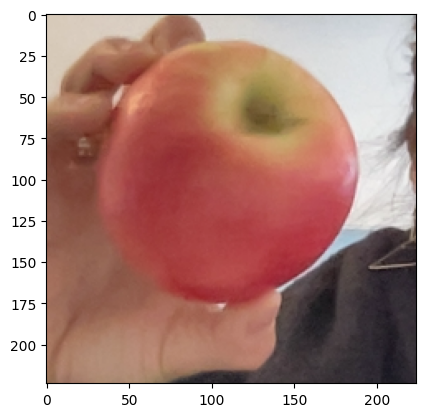

In [45]:
plt.imshow(Xtest[10]/255.0);

In [46]:
ytest[10]

0

In [47]:
# Make a prediction on the first sample in Xtest
prediction = model.predict(Xtest[[10]])

1/1 [==============================] - 0s 130ms/step


In [48]:
# Get the index of the highest predicted value
argmax = np.argmax(prediction)

# Print the result
print(argmax)

7452


In [51]:
predicted_class = class_names[pred_labels[10]]
print('Predicted class name:', predicted_class)

Predicted class name: apple


### Model VGG16

VGG16 is a pre-trained CNN model which is used for image classification. It is trained on a large and varied dataset and fine-tuned to fit image classification datasets with ease.

In [23]:
#Using VGG16
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model


In [24]:
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-3].output)

In [25]:
train_features = model.predict(Xtrain)
test_features = model.predict(Xtest)

6/6 [==============================] - 17s 3s/step


In [26]:
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

model2 = VGG16(weights='imagenet', include_top=False)

input_shape= model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (14,14,512)) # a new input tensor to be able to feed the desired layer

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

In [27]:
#create the model
new_model = Model(layer_input, x)


In [28]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [30]:

history2 = new_model.fit(train_features, ytrain, batch_size=128, epochs=20, validation_split=0.2, callbacks=[early_stop])

Epoch 1/20
4/4 [==============================] - 15s 4s/step - loss: 2.1897 - accuracy: 0.5179 - val_loss: 0.2892 - val_accuracy: 0.9603
Epoch 2/20
4/4 [==============================] - 16s 4s/step - loss: 0.7664 - accuracy: 0.8056 - val_loss: 0.2125 - val_accuracy: 0.9524
Epoch 3/20
4/4 [==============================] - 17s 4s/step - loss: 0.3751 - accuracy: 0.9087 - val_loss: 0.1925 - val_accuracy: 0.9683
Epoch 4/20
4/4 [==============================] - 16s 4s/step - loss: 0.4337 - accuracy: 0.9266 - val_loss: 0.2000 - val_accuracy: 0.9762
Epoch 5/20
4/4 [==============================] - 14s 4s/step - loss: 0.2305 - accuracy: 0.9762 - val_loss: 0.1059 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 15s 4s/step - loss: 0.1789 - accuracy: 0.9802 - val_loss: 0.1614 - val_accuracy: 0.9921
Epoch 7/20
4/4 [==============================] - 15s 4s/step - loss: 0.1718 - accuracy: 0.9821 - val_loss: 0.1149 - val_accuracy: 0.9921
Epoch 8/20
4/4 [==================

In [31]:
plot_accuracy(history2)

In [32]:
from sklearn.metrics import accuracy_score

predictions2 = new_model.predict(test_features)
pred_labels2 = np.argmax(predictions2, axis=1)
print('Accuracy: {}'.format(accuracy_score(ytest,pred_labels)))

6/6 [==============================] - 2s 273ms/step
Accuracy: 1.0


In [33]:
print(classification_report(ytest, pred_labels2,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        78
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        37

    accuracy                           1.00       188
   macro avg       1.00      1.00      1.00       188
weighted avg       1.00      1.00      1.00       188



In [36]:
model.save("model_VGG16.h5")

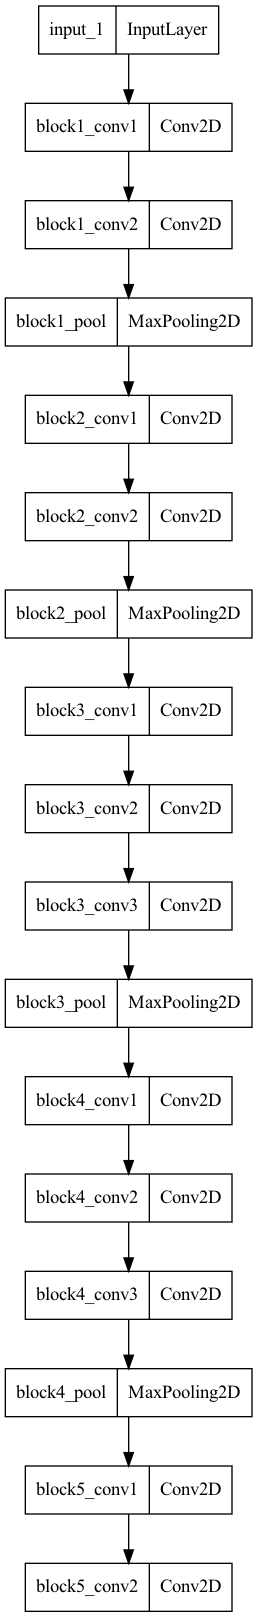

In [34]:
plot_model(model,
   to_file='model.png',
   show_shapes=False,
   show_layer_names=True,
   rankdir='TB', expand_nested=False, dpi=96
)

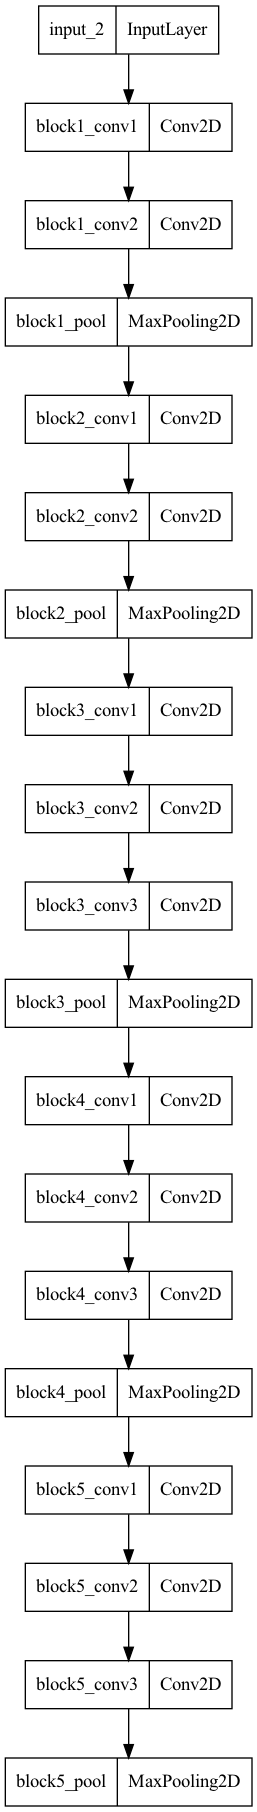

In [35]:
plot_model(model2,
   to_file='model2.png',
   show_shapes=False,
   show_layer_names=True,
   rankdir='TB', expand_nested=False, dpi=96
)